In [6]:
import re
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from datetime import datetime

nltk.download('punkt')
nltk.download('wordnet')

data = pd.read_csv('combined_messages.csv')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r"http\S+|www\S+", "", text)
        
        # Remove emojis
        text = re.sub(r"[^\x00-\x7F]+", "", text)  # Non-ASCII characters (emojis)
        
        # Remove special characters
        text = re.sub(r"[^\w\s]", "", text)
        
        # text to lowercase
        text = text.lower()
        
        # Lemmatization: Convert words to their base form
        text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
        
        return text.strip()  # Remove extra spaces
    return ""

# Ensure that the 'timestamp' column is in a consistent datetime format
def clean_timestamp(timestamp):
    try:
        return pd.to_datetime(timestamp, errors='coerce')  
    except Exception as e:
        return None  

data['cleaned_text'] = data['Message'].apply(clean_text)

data['Date'] = data['Date'].apply(clean_timestamp)

data = data.dropna(subset=['cleaned_text', 'Date'])

data = data[data['cleaned_text'] != ""]

data.to_csv('cleaned_messages.csv', index=False)


In [7]:
data

,Date,Sender,Message,cleaned_text
0,2024-12-06 17:33:40+00:00,-1001372819690,"Morgan Stanley, HSBC cut oil supply forecast, ...",morgan stanley hsbc cut oil supply forecast pr...
1,2024-12-06 17:33:40+00:00,-1001372819690,Bank of America expects Brent oil prices to av...,bank of america expects brent oil price to ave...
2,2024-12-06 17:33:40+00:00,-1001372819690,Tata Capital share are in demand in Unlisted M...,tata capital share are in demand in unlisted m...
3,2024-12-06 17:33:40+00:00,-1001372819690,FOR THE SHAREHOLDERS OF RECENTLY LISTED IPO OF...,for the shareholder of recently listed ipo of ...
4,2024-12-06 17:33:40+00:00,-1001372819690,India's One Of The Largest Home Appliances And...,india one of the largest home appliance and co...
...,...,...,...,...
9994,2022-01-24 06:45:38+00:00,-1001222486878,Nifty cracked beyond our targets 17350-330 hit...,nifty cracked beyond our target 17350330 hit e...
9995,2022-01-24 05:48:57+00:00,-1001222486878,Adani Enterprises looks making ending diagonal...,adani enterprise look making ending diagonal w...
9996,2022-01-24 04:56:21+00:00,-1001222486878,Case 2: Nifty Ending diagonal would continue s...,case 2 nifty ending diagonal would continue su...
9998,2022-01-24 04:52:55+00:00,-1001222486878,Nifty Ending diagonal Case 1 where C ends near...,nifty ending diagonal case 1 where c end nearb...


In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the necessary VADER lexicon
nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to C:\Users\NEHA
[nltk_data]     KL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
from textblob import TextBlob

sia = SentimentIntensityAnalyzer()

# Function to calculate VADER sentiment
def analyze_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    return scores['compound']  # Returns the overall sentiment score

# Function to calculate TextBlob sentiment
def analyze_sentiment_textblob(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply both sentiment analysis tools to the cleaned text
data['sentiment_vader'] = data['cleaned_text'].apply(analyze_sentiment_vader)
data['sentiment_textblob'] = data['cleaned_text'].apply(analyze_sentiment_textblob)

# Optionally, you can create a combined sentiment feature (e.g., average or weighted score)
data['sentiment_combined'] = (data['sentiment_vader'] + data['sentiment_textblob']) / 2


def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment'] = data['cleaned_text'].apply(get_sentiment)

In [10]:
stock_variants = {
    'AAPL': ['AAPL', 'Apple'],
    'TSLA': ['TSLA', 'Tesla'],
    'GOOGL': ['GOOGL', 'Google'],
    'AMZN': ['AMZN', 'Amazon'],
    'MSFT': ['MSFT', 'Microsoft']
}

for symbol, variants in stock_variants.items():
    data[f'count_{symbol}'] = data['cleaned_text'].apply(
        lambda x: sum([len(re.findall(r'\b' + variant + r'\b', str(x), re.IGNORECASE)) for variant in variants])
    )



In [11]:
for symbol in stock_variants.keys():
    print(data[data[f'count_{symbol}'] > 0][['Date', 'cleaned_text', f'count_{symbol}']])


                          Date  \
423  2024-11-14 12:31:36+00:00   
668  2024-11-08 10:31:09+00:00   
2759 2024-08-27 16:04:57+00:00   
3769 2024-07-25 03:16:23+00:00   
3790 2024-07-24 03:30:10+00:00   
4813 2024-06-24 13:02:52+00:00   
4935 2024-06-19 09:58:10+00:00   
6578 2023-07-20 18:13:30+00:00   

                                           cleaned_text  count_AAPL  
423   apple release finalcutpro11 along with update ...           1  
668   apple is building hostel facility for 100000 w...           1  
2759  apple ambitious plan to boost madeinindia ipho...           2  
3769  news headline from business news agency busine...           1  
3790  news headline from business news agency busine...           1  
4813  here are the key chip supplier for apple aapl ...           2  
4935  nvidia overtakes microsoft and apple to become...           1  
6578  i extensively use zerodha alert this is how i ...           1  
                          Date  \
153  2024-12-03 07:40:05+00:0

In [12]:
print(data['count_AAPL'].value_counts())


count_AAPL
0    8864
1       6
2       2
Name: count, dtype: int64


In [13]:
# Filter rows with count > 0 for any of the stock variants
filtered_data = data[
    (data[['count_AAPL', 'count_TSLA', 'count_GOOGL', 'count_AMZN', 'count_MSFT']] >= 0).any(axis=1)
]

# Save the filtered data with the count columns
filtered_data.to_csv('filtered_stock_data.csv', index=False)


In [14]:
df = pd.read_csv('filtered_stock_data.csv')
df

,Date,Sender,Message,cleaned_text,sentiment_vader,sentiment_textblob,sentiment_combined,sentiment,count_AAPL,count_TSLA,count_GOOGL,count_AMZN,count_MSFT
0,2024-12-06 17:33:40+00:00,-1001372819690,"Morgan Stanley, HSBC cut oil supply forecast, ...",morgan stanley hsbc cut oil supply forecast pr...,-0.5267,-0.051852,-0.289276,Negative,0,0,0,0,0
1,2024-12-06 17:33:40+00:00,-1001372819690,Bank of America expects Brent oil prices to av...,bank of america expects brent oil price to ave...,0.6597,-0.109375,0.275162,Negative,0,0,0,0,0
2,2024-12-06 17:33:40+00:00,-1001372819690,Tata Capital share are in demand in Unlisted M...,tata capital share are in demand in unlisted m...,0.1779,0.000000,0.088950,Neutral,0,0,0,0,0
3,2024-12-06 17:33:40+00:00,-1001372819690,FOR THE SHAREHOLDERS OF RECENTLY LISTED IPO OF...,for the shareholder of recently listed ipo of ...,0.8316,0.068182,0.449891,Positive,0,0,0,0,0
4,2024-12-06 17:33:40+00:00,-1001372819690,India's One Of The Largest Home Appliances And...,india one of the largest home appliance and co...,0.2732,0.139286,0.206243,Positive,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8867,2022-01-24 06:45:38+00:00,-1001222486878,Nifty cracked beyond our targets 17350-330 hit...,nifty cracked beyond our target 17350330 hit e...,-0.2732,-0.066667,-0.169933,Negative,0,0,0,0,0
8868,2022-01-24 05:48:57+00:00,-1001222486878,Adani Enterprises looks making ending diagonal...,adani enterprise look making ending diagonal w...,0.0000,0.000000,0.000000,Neutral,0,0,0,0,0
8869,2022-01-24 04:56:21+00:00,-1001222486878,Case 2: Nifty Ending diagonal would continue s...,case 2 nifty ending diagonal would continue su...,0.1531,0.000000,0.076550,Neutral,0,0,0,0,0
8870,2022-01-24 04:52:55+00:00,-1001222486878,Nifty Ending diagonal Case 1 where C ends near...,nifty ending diagonal case 1 where c end nearb...,-0.1531,0.000000,-0.076550,Neutral,0,0,0,0,0


In [15]:
#Topic Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

for index, topic in enumerate(lda.components_):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic #0:
['like', 'minute', 'trading', 'share', 'ipo', 'analysis', 'stockmarket', 'stock', 'nifty', 'video']
Topic #1:
['trade', 'margin', 'net', 'profit', 'qoq', 'q2', 'ebitda', 'q1', 'rupee', 'yoy']
Topic #2:
['pullback', 'high', 'day', 'near', 'low', 'level', 'chart', 'break', 'wave', 'nifty']
Topic #3:
['ipo', 'crore', 'buy', 'price', 'news', 'growth', 'ha', 'bank', 'say', 'india']
Topic #4:
['say', 'net', 'rupee', 'profit', 'india', 'revenue', 'company', 'crore', 'yoy', 'cr']


In [16]:
#Feature Extraction from Sentiment Analysis:

sentiment_counts = df['sentiment'].value_counts()

positive_count = sentiment_counts.get('Positive', 0)
negative_count = sentiment_counts.get('Negative', 0)
neutral_count = sentiment_counts.get('Neutral', 0)

from textblob import TextBlob
df['sentiment_combined'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

average_polarity = df['sentiment_combined'].mean()


In [17]:
#Date column in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

if df['Date'].isna().sum() > 0:
    print(f"Found {df['Date'].isna().sum()} invalid dates. Dropping them.")
    df = df.dropna(subset=['Date'])

df['week'] = df['Date'].dt.isocalendar().week

topic_probs = lda.transform(X)
df['topic_0_prob'] = topic_probs[:, 0]
df['topic_1_prob'] = topic_probs[:, 1]
df['topic_2_prob'] = topic_probs[:, 2]

topic_weekly_counts = df.groupby(['week'])[['topic_0_prob', 'topic_1_prob', 'topic_2_prob']].sum()
print(topic_weekly_counts)

      topic_0_prob  topic_1_prob  topic_2_prob
week                                          
1        11.949560      5.196256     49.537974
2        16.922879      9.036364     54.679924
3        18.702560      9.201069     63.634117
4        21.266763     10.880118     87.504133
5        13.223592      9.184290     88.390452
6        20.579187      9.027112     76.375394
7        13.253010      7.070111     67.620304
8        15.037932      7.780094     80.647779
9        15.816505      6.454002     61.569861
10       14.912981      7.614241     67.833867
11       17.758349      6.823746     60.528741
12       15.751919      5.920329     78.023177
13       10.009102      6.250183     65.359273
14       11.730605      9.415607     73.518963
15       13.407277      7.106523     65.111852
16       20.091073      6.957822     79.140379
17       11.277402      7.106944     60.031998
18        8.150724      4.053904     48.375731
19       10.075252      6.952694     73.257753
20        7.7

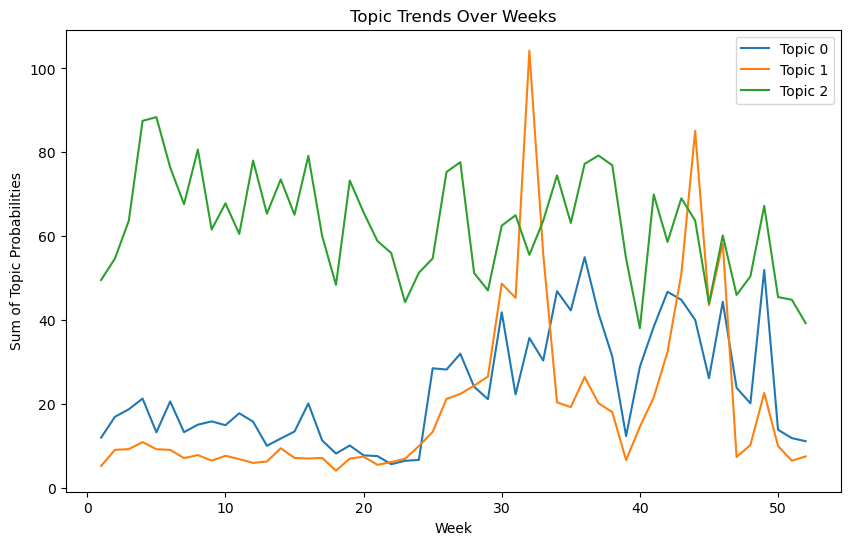

In [18]:
import matplotlib.pyplot as plt

topic_weekly_counts.plot(kind='line', figsize=(10, 6), title='Topic Trends Over Weeks')
plt.xlabel('Week')
plt.ylabel('Sum of Topic Probabilities')
plt.legend(['Topic 0', 'Topic 1', 'Topic 2'])
plt.show()


In [19]:
#Building Features for Model Input:

features = pd.DataFrame({
    'positive_count': positive_count,
    'negative_count': negative_count,
    'neutral_count': neutral_count,
    'average_polarity': average_polarity,
    'topic_0_prob': df['topic_0_prob'],
    'topic_1_prob': df['topic_1_prob'],
    'topic_2_prob': df['topic_2_prob'],
    'count_AAPL': df['count_AAPL'],
    'count_TSLA': df['count_TSLA'],
    'count_GOOGL': df['count_GOOGL'],
    'count_AMZN': df['count_AMZN'],
})

In [20]:
features.head()

,positive_count,negative_count,neutral_count,average_polarity,topic_0_prob,topic_1_prob,topic_2_prob,count_AAPL,count_TSLA,count_GOOGL,count_AMZN
0,3327,1866,3679,0.052631,0.006124,0.006072,0.006100,0,0,0,0
1,3327,1866,3679,0.052631,0.006557,0.006504,0.006644,0,0,0,0
2,3327,1866,3679,0.052631,0.029366,0.028643,0.028654,0,0,0,0
3,3327,1866,3679,0.052631,0.452606,0.007710,0.007703,0,0,0,0
4,3327,1866,3679,0.052631,0.087981,0.004891,0.004880,0,0,0,0


In [21]:
#Stock Movement Label:

import yfinance as yf

stock_data = yf.download('AAPL', start='2023-01-01', end='2024-01-01')

df['stock_price'] = stock_data['Close']
df['price_change'] = df['stock_price'].pct_change() 
df['stock_movement'] = df['price_change'].apply(
    lambda x: 'up' if x > 0.01 else ('down' if x < -0.01 else 'neutral')
)

y = df['stock_movement']


[*********************100%***********************]  1 of 1 completed
C:\Users\NEHA KL\AppData\Local\Temp\ipykernel_19860\21760123.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['price_change'] = df['stock_price'].pct_change()


In [27]:
X = features  
y = df['stock_movement']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (8872, 11)
Shape of y: (8872,)


In [28]:
#Prediction Model:

from sklearn.model_selection import train_test_split

X = features
y = df['stock_movement']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00      2662

    accuracy                           1.00      2662
   macro avg       1.00      1.00      1.00      2662
weighted avg       1.00      1.00      1.00      2662


Confusion Matrix:
[[2662]]


C:\Users\NEHA KL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


C:\Users\NEHA KL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


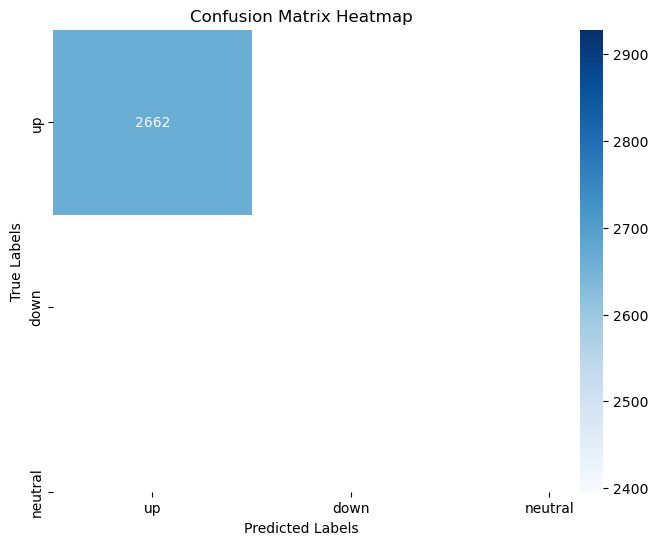

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['up', 'down', 'neutral'], yticklabels=['up', 'down', 'neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
pip install imbalanced-learn
